# Peak-trough performance evaluation

## 1. Load libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import os
import sys
import glob

# Import piezo/fatigue sensor libraries
sys.path.insert(0, "../../simulation/scripts/lib")
from piezo import Piezo
from fatigue_sensor import FatigueSensor, create_sensor

import matplotlib.pyplot as plt  # library to plot graphs in Python
import matplotlib.dates as mdates
import pylab as pl

from matplotlib import rc
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as patches

from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Create linestyles for black and white plots
ls = ["-","--",":","-."]
markers = ["o","s","d"]
clrs = ["k"]

linestyles = list()
for l in ls:
    for m in markers:
        for c in clrs:
            linestyles.append(m+l+c)

params = {'legend.fontsize': 'x-large',
          'axes.titlesize': 'x-large',
          'figure.figsize': (14.0, 5.0),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## 2. Create sensor

Let's create the fatigue sensor object by calling the function create_sensor(). We will use it later in the code to convert voltage data into ustrain data.

In [2]:
# Create sensor
sensor = create_sensor()
sensor.getFirstStage().setCf(4e-9) # set C1
sensor.getSecondStage().setCd(4e-6) # set C2

## 3 Extract data

We will import the following data:
- **D1** (*data-from-conventional.csv*): contains data obtained with the [NZ32-SC151 development platform](http://wiki.modtronix.com/doku.php?id=products:nz-stm32:nz32-sc151). This platform has a STM32L151 microprocessor featuring a 12-bit analogue-to-digital converter (ADC). Sampling rate is 64Hz.
- **D2** (*data-from-fatigue-sensor.csv*): contains peak values (local maximum and minimum values) obtained with our peak-trough hardware detector interfaced with a NZ32-S151 platform.

In [3]:
experiment_path = 'input/exp-'

# Load dataset D1
df1 = pd.read_csv('data/data-from-conventional.csv')
# Load dataset D2
df2 = pd.read_csv('data/data-from-fatigue-sensor.csv')

datasets = {"df1": df1, "df2": df2}

### 3.1 Explore the data

#### D1: Continuous measurement of piezoelectric sensor output

In [4]:
df1.head()

timestamp     clock   voltage  Vpp  Freq  \
0  2019-03-12 14:42:16.151753  3443.648  1.373175  0.6     1   
1  2019-03-12 14:42:16.167561  3443.664  1.369952  0.6     1   
2  2019-03-12 14:42:16.183472  3443.680  1.386065  0.6     1   
3  2019-03-12 14:42:16.199499  3443.695  1.385260  0.6     1   
4  2019-03-12 14:42:16.218079  3443.711  1.393317  0.6     1   

           ExpDatetime  SamplesPerSecond  SensorLength  SensorWidth  \
0  2019-03-12 14:41:59                64          0.03        0.012   
1  2019-03-12 14:41:59                64          0.03        0.012   
2  2019-03-12 14:41:59                64          0.03        0.012   
3  2019-03-12 14:41:59                64          0.03        0.012   
4  2019-03-12 14:41:59                64          0.03        0.012   

   SensorThickness       ...           SensorD32     SensorD33  \
0         0.000028       ...        2.300000e-12 -3.300000e-11   
1         0.000028       ...        2.300000e-12 -3.300000e-11   
2         0.000028       ...        2.300000e-12 -3.300000e-11   
3         0.000028       ...        2.300000e-12 -3.300000e-11   
4         0.000028       ...        2.300000e-12 -3.300000e-11   

   SensorYoungsModulus  SensorRelPermittivity  SensorStage1Rf  SensorStage1Cf  \
0         4.000000e+09                     12     100000000.0    4.000000e-09   
1         4.000000e+09                     12     100000000.0    4.000000e-09   
2         4.000000e+09                     12     100000000.0    4.000000e-09   
3         4.000000e+09                     12     100000000.0    4.000000e-09   
4         4.000000e+09                     12     100000000.0    4.000000e-09   

   SensorStage2Rf  SensorStage2RnonIn  SensorStage2Rd  SensorStage2Cd  
0      10000000.0             47000.0          1000.0        0.000004  
1      10000000.0             47000.0          1000.0        0.000004  
2      10000000.0             47000.0          1000.0        0.000004  
3      10000000.0             47000.0          1000.0        0.000004  
4      10000000.0             47000.0          1000.0        0.000004  

[5 rows x 21 columns]

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185262 entries, 0 to 185261
Data columns (total 21 columns):
timestamp                185262 non-null object
clock                    185262 non-null float64
voltage                  185262 non-null float64
Vpp                      185262 non-null float64
Freq                     185262 non-null int64
ExpDatetime              185262 non-null object
SamplesPerSecond         185262 non-null int64
SensorLength             185262 non-null float64
SensorWidth              185262 non-null float64
SensorThickness          185262 non-null float64
SensorD31                185262 non-null float64
SensorD32                185262 non-null float64
SensorD33                185262 non-null float64
SensorYoungsModulus      185262 non-null float64
SensorRelPermittivity    185262 non-null int64
SensorStage1Rf           185262 non-null float64
SensorStage1Cf           185262 non-null float64
SensorStage2Rf           185262 non-null float64
SensorStage2Rno

#### D2: Peak/Trough data obtained with our solution

In [6]:
df2.head()

timestamp  clock  voltage  Vpp  Freq          ExpDatetime  \
0  2019-03-12 14:42:23.846083  0.031    1.768  0.6     1  2019-03-12 14:42:17   
1  2019-03-12 14:42:23.878053  0.031    1.715  0.6     1  2019-03-12 14:42:17   
2  2019-03-12 14:42:23.894016  0.031    1.672  0.6     1  2019-03-12 14:42:17   
3  2019-03-12 14:42:24.346844  0.031    1.520  0.6     1  2019-03-12 14:42:17   
4  2019-03-12 14:42:24.836365  0.031    1.776  0.6     1  2019-03-12 14:42:17   

   SensorLength  SensorWidth  SensorThickness     SensorD31     SensorD32  \
0          0.03        0.012         0.000028  2.300000e-11  2.300000e-12   
1          0.03        0.012         0.000028  2.300000e-11  2.300000e-12   
2          0.03        0.012         0.000028  2.300000e-11  2.300000e-12   
3          0.03        0.012         0.000028  2.300000e-11  2.300000e-12   
4          0.03        0.012         0.000028  2.300000e-11  2.300000e-12   

      SensorD33  SensorYoungsModulus  SensorRelPermittivity  SensorStage1Rf  \
0 -3.300000e-11         4.000000e+09                     12     100000000.0   
1 -3.300000e-11         4.000000e+09                     12     100000000.0   
2 -3.300000e-11         4.000000e+09                     12     100000000.0   
3 -3.300000e-11         4.000000e+09                     12     100000000.0   
4 -3.300000e-11         4.000000e+09                     12     100000000.0   

   SensorStage1Cf  SensorStage2Rf  SensorStage2RnonIn  SensorStage2Rd  \
0    4.000000e-09      10000000.0             47000.0          1000.0   
1    4.000000e-09      10000000.0             47000.0          1000.0   
2    4.000000e-09      10000000.0             47000.0          1000.0   
3    4.000000e-09      10000000.0             47000.0          1000.0   
4    4.000000e-09      10000000.0             47000.0          1000.0   

   SensorStage2Cd  
0        0.000004  
1        0.000004  
2        0.000004  
3        0.000004  
4        0.000004

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50918 entries, 0 to 50917
Data columns (total 20 columns):
timestamp                50918 non-null object
clock                    50918 non-null float64
voltage                  50918 non-null float64
Vpp                      50918 non-null float64
Freq                     50918 non-null int64
ExpDatetime              50918 non-null object
SensorLength             50918 non-null float64
SensorWidth              50918 non-null float64
SensorThickness          50918 non-null float64
SensorD31                50918 non-null float64
SensorD32                50918 non-null float64
SensorD33                50918 non-null float64
SensorYoungsModulus      50918 non-null float64
SensorRelPermittivity    50918 non-null int64
SensorStage1Rf           50918 non-null float64
SensorStage1Cf           50918 non-null float64
SensorStage2Rf           50918 non-null float64
SensorStage2RnonIn       50918 non-null float64
SensorStage2Rd           50918 no

### 3.2 Plotting

In [8]:
def plot_datasets(datasets, Vpp, Freq, ustrainUnits=False, save2fig=False):
    # Retrieve the datasets from the dictionary "datasets"
    df1 = datasets['df1']
    df2 = datasets['df2']
    
    # Extract voltage and timestamp data from the dataset
    df1_voltage = df1.loc[(df1.Vpp == Vpp) & (df1.Freq == Freq)].voltage
    df1_timestamp = pd.to_datetime(df1.loc[(df1.Vpp == Vpp) & (df1.Freq == Freq)].timestamp)
    df2_voltage = df2.loc[(df2.Vpp == Vpp) & (df2.Freq == Freq)].voltage
    df2_timestamp = pd.to_datetime(df2.loc[(df2.Vpp == Vpp) & (df2.Freq == Freq)].timestamp)
    
    # Create figure and axes
    fig = plt.figure(figsize=(8.0, 5.0))
    ax = fig.add_subplot(111)
    
    xdf1, xdf2 = df1_timestamp.values.astype('float64')/1e9, df2_timestamp.values.astype('float64')/1e9
    diff = abs(xdf1[0] - xdf2[0])
    if(xdf1[0] > xdf2[0]):
        xdf1 -= xdf1[0]
        xdf2 -= xdf2[0] + diff
    else:
        xdf2 -= xdf2[0]
        xdf1 -= xdf1[0] + diff
        
    if ustrainUnits == True:
        df1_ustrain = sensor.convert2ustrain(df1_voltage)
        df2_ustrain = sensor.convert2ustrain(df2_voltage)
        ydf1, ydf2 = df1_ustrain.values, df2_ustrain.values
    else:
        ydf1, ydf2 = df1_voltage.values, df2_voltage.values

    ax.plot(xdf2, ydf2, label='Our solution', color=colors['saddlebrown'],zorder=1)
    ax.plot(xdf1, ydf1, label='Conventional approach', color=colors['goldenrod'],zorder=0)
        
    # Plot    
    # Axes limits
    ax.set_xlim([0,30])

    # Create a Rectangle patch
    import matplotlib.patches as patches
    
    if ustrainUnits == False:
        top_rect = patches.Rectangle((0.5,1.90),29.0,.08,
                                 linewidth=2,edgecolor='k',facecolor='none',zorder=3)
        bottom_rect = patches.Rectangle((0.5,1.32),29.0,.08,
                                 linewidth=2,edgecolor='k',facecolor='none',zorder=3)
    else:
        top_rect = patches.Rectangle((0.5,30),29.0,12,
                                 linewidth=2,edgecolor='k',facecolor='none',zorder=3)
        bottom_rect = patches.Rectangle((0.5,-42),29.0,12,
                                 linewidth=2,edgecolor='k',facecolor='none',zorder=3)
    # Add the patch to the Axes
    ax.add_patch(top_rect)
    ax.add_patch(bottom_rect)
    
    # Annotations
    if ustrainUnits == False:
        xy_x, xy_y, xytext_y = 10, 1.40, 1.90
    else:
        xy_x, xy_y, xytext_y = 10, -30, 30
        
    ax.annotate("",
            xy=(xy_x, xy_y), xycoords='data',
            xytext=(xy_x, xytext_y), textcoords='data',
            size=20,
            arrowprops=dict(arrowstyle="<->", fc="0.6",
                            connectionstyle="arc3", lw=2),
            zorder=3)

    ax.annotate("Peak/Trough difference",
            xy=(0.5 * xy_x, 0.5 * (xy_y + xytext_y)), xycoords='data',
            xytext=(0.5 * xy_x, 0.5 * (xy_y + xytext_y)), textcoords='data',
            bbox=dict(boxstyle="Square", fc="w"),
            size=14, zorder=3)

    # Grid    
    ax.grid(color='gray', linestyle='dotted')
    # Legend
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1,
            borderaxespad=0, frameon=True, prop={'size': 14})
    
    # Axes labels
    if ustrainUnits == False: ax.set_ylabel(r'Voltage (V)')
    else: ax.set_ylabel(r'Strain ($\mu\epsilon$)')
    ax.set_xlabel(r'Time (s)')
    
    # Some cosmetics
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Adjust plot to plotting area
    plt.tight_layout()
    
    # Save figure
    if save2fig == True:
        if not os.path.exists('figures'):
            os.makedirs('figures')
        if ustrainUnits == False: 
            figurename = 'figures/signal-diff-in-volts.eps'
        else: 
            figurename = 'figures/signal-diff-in-ustrain.eps'
        plt.savefig(figurename, 
                    transparent=True, format='eps', dpi=300, 
                    bbox_inches = 'tight', pad_inches = 0)

    plt.show()

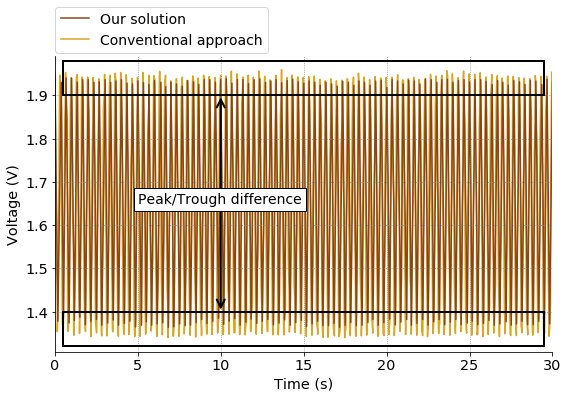

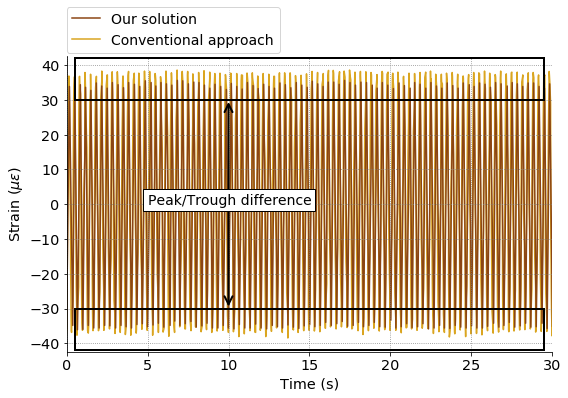

In [9]:
plot_datasets(datasets, 0.6, 3, ustrainUnits=False, save2fig=False)
plot_datasets(datasets, 0.6, 3, ustrainUnits=True, save2fig=False)

## 4. Peak comparison

We will process dataset D1 to find peaks using a peak finding algorithm in software. We will use the library [peakutils](https://peakutils.readthedocs.io/en/latest/) and an adapted version of the function [plot_peaks_lows_highs](https://github.com/MonsieurV/py-findpeaks/blob/master/tests/lows_and_highs.py) written by Yoan Tournade to find local maximum and local mimimum peaks using peakutils.

### 4.1 Extract peaks and troughs from df1

In [10]:
try:
    import peakutils.peak
except ImportError:
    print('peakutils library is not available.')

def find_peaks_troughs(df, Vpp, Freq, threshold=0.03, min_dist=1, verbose = 0):
    # Retrieve the datasets from the dictionary "datasets"
    x = np.array(df.loc[(df.Vpp == Vpp) & (df.Freq == Freq)].voltage)
    y = np.array(pd.to_datetime(df.loc[(df.Vpp == Vpp) & (df.Freq == Freq)].timestamp))
    
    if verbose == 1: print('Detect peaks with minimum height and distance filters.')
    peaks = peakutils.peak.indexes(
        x,
        thres=threshold/max(x), min_dist=min_dist
    )
    if verbose == 1: print('Indexes for peaks are: %s' % (peaks))
    
    if verbose == 1: print('Detect low peaks with minimum height and distance filters.')
    # Invert the signal.
    x_Inverted = x * -1
    troughs = peakutils.peak.indexes(
        x_Inverted,
        thres=threshold/max(x_Inverted), min_dist=min_dist
    )
    if verbose == 1: print('Indexes for troughs are: %s' % (troughs))
    
    params = {"x": x.reshape((len(x), 1)), 
              "y": y.reshape((len(y), 1)), 
              "peaks": peaks, 
              "troughs": troughs,
              "Vpp": Vpp,
              "Freq": Freq,
              "threshold": threshold,
              "min_dist": min_dist}
    return params
    
def plot_peaks_troughs(params, algorithm=None, mph=None, mpd=None, ustrainUnits=False, save2fig=False):
    """Plot results of the peak dectection."""
    x = params['x']
    y = params['y']
    peaks = params['peaks']
    troughs = params['troughs']
    Vpp = params['Vpp']
    Freq = params['Freq']
    
    if ustrainUnits == True: x = sensor.convert2ustrain(x)
    
    y = y.astype('float64')/1e9
    y -= y[0]
    
    fig = plt.figure(figsize=(8.0, 4.0))
    ax = fig.add_subplot(111)
    
    ax.plot(y, x, 'b', lw=1)
    if peaks.size > 0:
        if ustrainUnits == True: label = 'Trough'
        else: label = 'Peak'
        label = label + 's' if peaks.size > 1 else label
        ax.plot(y[peaks], x[peaks], '+', mfc=None, mec='r', mew=2, ms=8,
                label='%d %s' % (peaks.size, label))

    if troughs.size > 0:
        if ustrainUnits == True: label = 'Peak'
        else: label = 'Trough'
            
        label = label + 's' if troughs.size > 1 else label
        ax.plot(y[troughs], x[troughs], '+', mfc=None, mec='g', mew=2, ms=8,
                label='%d %s' % (troughs.size, label))
    
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1,
            borderaxespad=0, frameon=True, prop={'size': 14})
    
    ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
    yrange = ymax - ymin if ymax > ymin else 1
    ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
    
    ax.set_xlabel('Time (s)')
    if ustrainUnits == False: ax.set_ylabel(r'Voltage (V)')
    else: ax.set_ylabel(r'Strain ($\mu\epsilon$)')
    
    ax.set_xlim([0, 60])
    
    #ax.set_title(r'(Vpp=%sV, freq=%sHz)' % (Vpp, Freq))
    ax.grid(color='gray', linestyle='dotted')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    fig.tight_layout()
    plt.show()

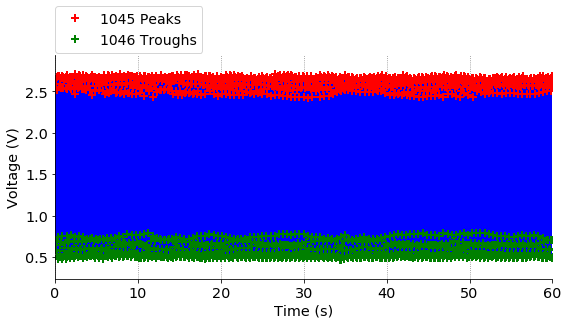

In [11]:
Vpp = 1.6
Freq = 14

# Adjust threshold depending on frequency (values are manually chosen based on observation)
if Freq < 2: min_dist = 60 
elif Freq < 5: min_dist = 10 
else: min_dist=1

df1_peakTrough_params = find_peaks_troughs(datasets['df1'], Vpp, Freq, min_dist=min_dist)
plot_peaks_troughs(df1_peakTrough_params, ustrainUnits=False)

### 4.2 Match peak/trough data from both datasets

In [12]:
def get_compare_params(datasets, df1_params):    
    df2 = datasets['df2']
    
    df1_x = df1_params['x']
    df1_y = df1_params['y']
    df1_peaks = df1_params['peaks']
    df1_troughs = df1_params['troughs']
  
    Vpp = df1_params['Vpp']
    Freq = df1_params['Freq']
    
    df2_x = np.array(df2.loc[(df2.Vpp == Vpp) & (df2.Freq == Freq)].voltage)
    df2_y = np.array(pd.to_datetime(df2.loc[(df2.Vpp == Vpp) & (df2.Freq == Freq)].timestamp)) 
    df2_peaks = df2_x >= sensor.getFirstStage().getVref()
    df2_troughs = df2_x < sensor.getFirstStage().getVref()
    
    cparams = {'df1_x': df1_x,
               'df1_y': df1_y,
               'df1_peaks': df1_peaks,
               'df1_troughs': df1_troughs,
               'df2_x': df2_x.reshape((len(df2_x), 1)),
               'df2_y': df2_y.reshape((len(df2_y), 1)),
               'df2_peaks': df2_peaks,
               'df2_troughs': df2_troughs,
               'Vpp': Vpp,
               'Freq': Freq }
    return cparams

In [13]:
def plot_compare_peaks_troughs(cparams, ustrainUnits=False, save2fig=False):
    # Retrieve relevant parameters from the dictionary "cparams"
    df1_x = cparams['df1_x']
    df1_y = cparams['df1_y']
    df1_peaks = cparams['df1_peaks']
    df1_troughs = cparams['df1_troughs']
    df2_x = cparams['df2_x']
    df2_y = cparams['df2_y']
    df2_peaks = cparams['df2_peaks']
    df2_troughs = cparams['df2_troughs']
    Vpp = cparams['Vpp']
    Freq = cparams['Freq']
            
    if ustrainUnits == True:
        df1_x = sensor.convert2ustrain(df1_x)
        df2_x = sensor.convert2ustrain(df2_x)
      
    fig = plt.figure(figsize=(8.0, 4.0))
    ax = fig.add_subplot(111)
    
    df1_y, df2_y = df1_y.astype('float64')/1e9, df2_y.astype('float64')/1e9
    diff = abs(df1_y[0] - df2_y[0])
    if(df1_y[0] > df2_y[0]):
        df1_y -= df1_y[0]
        df2_y -= df2_y[0] + diff
    else:
        df2_y -= df2_y[0]
        df1_y -= df1_y[0] + diff
    
    # Plot high peaks
    if df1_peaks.size:
        if ustrainUnits == True: label = '(sw) Trough'
        else: label = '(sw) Peak'
        label = label + 's' if df1_peaks.size > 1 else label
        ax.plot(df1_y[df1_peaks], df1_x[df1_peaks], '+', mfc=None, mec='r', mew=2, ms=8,
                label='%s' % (label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    
    if df2_peaks.size:
        if ustrainUnits == True: label = '(hw) Trough'
        else: label = '(hw) Peak'
        label = label + 's' if df2_peaks.size > 1 else label
        ax.plot(df2_y[df2_peaks], df2_x[df2_peaks], '.', mfc=None, mec='g', mew=2, ms=8,
                label='%s' % (label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    
    # Plot low peaks
    if df1_troughs.size:
        if ustrainUnits == True: label = '(sw) Peak'
        else: label = '(sw) Trough'
        label = label + 's' if df1_troughs.size > 1 else label
        ax.plot(df1_y[df1_troughs], df1_x[df1_troughs], '+', mfc=None, mec='r', mew=2, ms=8,
                label='%s' % (label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    
    if df2_troughs.size:
        if ustrainUnits == True: label = '(hw) Peak'
        else: label = '(hw) Trough'
        label = label + 's' if df2_troughs.size > 1 else label
        ax.plot(df2_y[df2_troughs], df2_x[df2_troughs], '.', mfc=None, mec='g', mew=2, ms=8,
                label='%s' % (label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
        
    
    ax.set_xlim([0, 60])
    ax.set_xlabel(r'Timestamp')
    if ustrainUnits == False:
        ax.set_ylabel(r'Voltage (V)')
    else:
        ax.set_ylabel(r'Strain ($\mu\epsilon$)')
    
    ax.set_title('(Vpp=%sV, freq=%sHz)' % (Vpp, Freq))
    
    ax.grid(color='gray', linestyle='dotted')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    fig.tight_layout()
    plt.show()

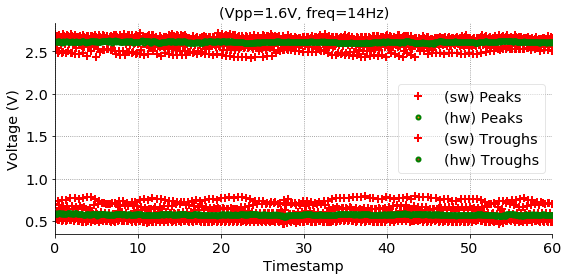

In [14]:
cparams = get_compare_params(datasets, df1_peakTrough_params)
plot_compare_peaks_troughs(cparams)

### 4.2.1 Algorithm for matching peaks and troughs from both acquisition systems

In [15]:
def match_peaks_troughs_from_datasets(cparams):
    # Retrieve relevant parameters from the dictionary "cparams"
    df1_x = cparams['df1_x']
    df1_y = cparams['df1_y']
    df1_peaks = cparams['df1_peaks']
    df1_troughs = cparams['df1_troughs']
    df2_x = cparams['df2_x']
    df2_y = cparams['df2_y']
    df2_peaks = cparams['df2_peaks']
    df2_troughs = cparams['df2_troughs']
    Vpp = cparams['Vpp']
    Freq = cparams['Freq']

    df1_x_peaks = df1_x[df1_peaks]
    df1_x_troughs = df1_x[df1_troughs]
    df1_y_peaks = df1_y[df1_peaks]
    df1_y_troughs = df1_y[df1_troughs]

    df2_x_peaks = df2_x[df2_peaks]
    df2_x_troughs = df2_x[df2_troughs]
    df2_y_peaks = df2_y[df2_peaks]
    df2_y_troughs = df2_y[df2_troughs]
    
    # First the peaks
    points_idx = {}
    for i, item in enumerate(df1_y_troughs):
        try: points_idx[i] = points_idx.get(i, 0) + next(x[0] for x in enumerate(df2_y_peaks) if x[1] >= item)
        except StopIteration: break
    # Remove duplicates:
    #   Flip dictionary around into a reverse multidict, mapping each value to all of the keys it maps to
    rev_points_idx = {}
    for key, value in points_idx.items(): rev_points_idx.setdefault(value, set()).add(key)
    #   Look for keys in the multidict that have more than 1 value
    peaks_idx = [[next(iter(values)), key] for key, values in rev_points_idx.items() if len(values) == 1]
        
    # Second the low peaks
    points_idx = {}
    for i, item in enumerate(df1_y_troughs):
        try: points_idx[i] = points_idx.get(i, 0) + next(x[0] for x in enumerate(df2_y_troughs) if x[1] >= item)
        except StopIteration: break
    # Remove duplicates:
    #   Flip dictionary around into a reverse multidict, mapping each value to all of the keys it maps to
    rev_points_idx = {}
    for key, value in points_idx.items(): rev_points_idx.setdefault(value, set()).add(key)
    #   Look for keys in the multidict that have more than 1 value
    troughs_idx = [[next(iter(values)), key] for key, values in rev_points_idx.items() if len(values) == 1]
    
    params = { 'df1_x_peaks': df1_x_peaks,
               'df1_y_peaks': df1_y_peaks,
               'df1_x_troughs': df1_x_troughs,
               'df1_y_troughs': df1_y_troughs,
               'df2_x_peaks': df2_x_peaks,
               'df2_y_peaks': df2_y_peaks,
               'df2_x_troughs': df2_x_troughs,
               'df2_y_troughs': df2_y_troughs,
               'peaks_idx': np.array(peaks_idx),
               'troughs_idx': np.array(troughs_idx),
               'Vpp': Vpp,
               'Freq': Freq }
    return params

In [16]:
def plot_compare_peaks_troughs_after_matching(match_params, ustrainUnits=False, save2fig=False):
    # Retrieve relevant parameters from the dictionary "cparams"
    df1_x_peaks = match_params['df1_x_peaks']
    df1_y_peaks = match_params['df1_y_peaks']
    df2_x_peaks = match_params['df2_x_peaks']
    df2_y_peaks = match_params['df2_y_peaks']
    df1_x_troughs = match_params['df1_x_troughs']
    df1_y_troughs = match_params['df1_y_troughs']
    df2_x_troughs = match_params['df2_x_troughs']
    df2_y_troughs = match_params['df2_y_troughs']
    peaks = match_params['peaks_idx']
    troughs = match_params['troughs_idx']
    Vpp = match_params['Vpp']
    Freq = match_params['Freq']
            
    if ustrainUnits == True:
        df1_x_peaks = sensor.convert2ustrain(df1_x_peaks)
        df2_x_peaks = sensor.convert2ustrain(df2_x_peaks)
        df1_x_troughs = sensor.convert2ustrain(df1_x_troughs)
        df2_x_troughs = sensor.convert2ustrain(df2_x_troughs)
    
    df1_y_peaks, df2_y_peaks = df1_y_peaks.astype('float64')/1e9, df2_y_peaks.astype('float64')/1e9
    df1_y_troughs, df2_y_troughs = df1_y_troughs.astype('float64')/1e9, df2_y_troughs.astype('float64')/1e9
    
    diff_peaks = abs(df1_y_peaks[0] - df2_y_peaks[0])
    diff_troughs = abs(df1_y_troughs[0] - df2_y_troughs[0])
    
    if(df1_y_peaks[0] > df2_y_peaks[0]):
        df1_y_peaks -= df1_y_peaks[0]
        df2_y_peaks -= df2_y_peaks[0] + diff_peaks
    else:
        df2_y_peaks -= df2_y_peaks[0]
        df1_y_peaks -= df1_y_peaks[0] + diff_peaks
        
    if(df1_y_troughs[0] > df2_y_troughs[0]):
        df1_y_troughs -= df1_y_troughs[0]
        df2_y_troughs -= df2_y_lows[0] + diff_troughs
    else:
        df2_y_troughs -= df2_y_troughs[0]
        df1_y_troughs -= df1_y_troughs[0] + diff_troughs
    
    fig = plt.figure(figsize=(8.0, 4.0))
    ax = fig.add_subplot(111)
    # Plot high peaks
    if peaks.shape[0] > 0:
        ax.plot(df1_y_peaks[peaks[:,0]], df1_x_peaks[peaks[:,0]], '+', mfc=None, mec='b', mew=2, ms=8,
                label='Conventional approach')
        ax.plot(df2_y_peaks[peaks[:,1]], df2_x_peaks[peaks[:,1]], '.', mfc=None, mec='#FF8C00', mew=2, ms=8,
                label='Our solution')
    if troughs.shape[0] > 0:
        ax.plot(df1_y_troughs[troughs[:,0]], df1_x_troughs[troughs[:,0]], '+', mfc=None, mec='b', mew=2, ms=8)
        ax.plot(df2_y_troughs[troughs[:,1]], df2_x_troughs[troughs[:,1]], '.', mfc=None, mec='#FF8C00', mew=2, ms=8)
    
    ax.legend(loc='best', framealpha=.5, numpoints=1)
    
    ax.set_xlabel(r'Timestamp')
    if ustrainUnits == False:
        ax.set_ylabel(r'Voltage (V)')
    else:
        ax.set_ylabel(r'Strain ($\mu\epsilon$)')
    ax.set_title('(Vpp=%sV, freq=%sHz)' % (Vpp, Freq))
    ax.grid(color='gray', linestyle='dotted')
    
    ax.set_xlim([0, 60])
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    fig.tight_layout()
    plt.show()

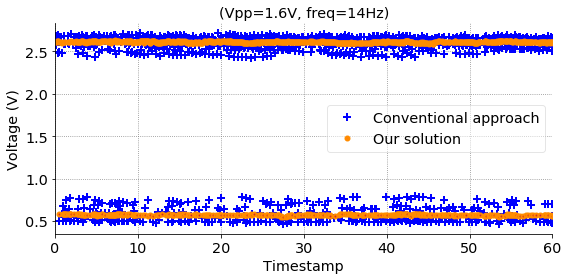

In [17]:
match_params = match_peaks_troughs_from_datasets(cparams)
plot_compare_peaks_troughs_after_matching(match_params)

### 4.3 Compute measurement error

In [18]:
def compute_measurement_error(match_params, sensor, confidence=0.95, ustrainUnits=False, relative=False):
    import scipy.stats
    # Retrieve relevant parameters from the dictionary "cparams"
    # Peaks
    #  dataset 1
    df1_x_peaks = match_params['df1_x_peaks']
    df1_y_peaks = match_params['df1_y_peaks']
    #  dataset 2
    df2_x_peaks = match_params['df2_x_peaks']
    df2_y_peaks = match_params['df2_y_peaks']
    # Troughs
    #  dataset 1
    df1_x_troughs = match_params['df1_x_troughs']
    df1_y_troughs = match_params['df1_y_troughs']
    #  dataset 2
    df2_x_troughs = match_params['df2_x_troughs']
    df2_y_troughs = match_params['df2_y_troughs']
    
    #  Index peaks
    peaks = match_params['peaks_idx']
    #  Index troughs
    troughs = match_params['troughs_idx']
    
    # Peak-to-peak voltage (Vpp)
    Vpp = match_params['Vpp']
    # Frequency (Freq)
    Freq = match_params['Freq']
    
    df1_x_peaks = abs(df1_x_peaks - sensor.getFirstStage().getVref())
    df2_x_peaks = abs(df2_x_peaks - sensor.getFirstStage().getVref())    
    df1_x_troughs = abs(df1_x_troughs - sensor.getFirstStage().getVref())
    df2_x_troughs = abs(df2_x_troughs - sensor.getFirstStage().getVref())
    
    if ustrainUnits == True:
        # Convert to strain
        df1_x_peaks = sensor.convert2ustrain(df1_x_peaks, voffset=False)
        df2_x_peaks = sensor.convert2ustrain(df2_x_peaks, voffset=False)
        df1_x_troughs = sensor.convert2ustrain(df1_x_troughs, voffset=False)
        df2_x_troughs = sensor.convert2ustrain(df2_x_troughs, voffset=False)
    
    # Compute error
    #  Peaks
    error_peaks = abs(np.subtract( df1_x_peaks[peaks[:,0]], df2_x_peaks[peaks[:,1]] ))
    #  Troughs
    error_troughs = abs(np.subtract( df1_x_troughs[troughs[:,0]], df2_x_troughs[troughs[:,1]] ))
    
    if relative == True:
        error_peaks = abs(np.divide(error_peaks, df1_x_peaks[peaks[:,0]])) * 100
        error_troughs = abs(np.divide(error_troughs, df1_x_troughs[troughs[:,0]])) * 100
        
    # Append errors
    error = np.concatenate((error_peaks, error_troughs), axis=0)
    
    # Compute mean and confidence interval
    #  Peaks
    peaks_mean, se = np.mean(error_peaks), scipy.stats.sem(error_peaks)
    peaks_err = (se * scipy.stats.t.ppf((1 + confidence) / 2., len(error_peaks)-1))[0]
    #  Troughs
    troughs_mean, se = np.mean(error_troughs), scipy.stats.sem(error_troughs)
    troughs_err = (se * scipy.stats.t.ppf((1 + confidence) / 2., len(error_troughs)-1))[0]
    
    error_mean, se = np.mean(error), scipy.stats.sem(error)
    error_err = (se * scipy.stats.t.ppf((1 + confidence) / 2., len(error)-1))[0]
    
    # Save to dictionary
    params = {'error_mean': error_mean,
              'error_err': error_err,
              'peaks_mean': peaks_mean,
              'peaks_err': peaks_err,
              'troughs_mean': troughs_mean,
              'troughs_err': troughs_err,
              'Vpp': Vpp,
              'Freq': Freq }
    
    return params

In [19]:
compute_measurement_error(match_params, sensor=sensor)

{'error_mean': 0.06527983795130142,
 'error_err': 0.00254759359817207,
 'peaks_mean': 0.057405209781209755,
 'peaks_err': 0.0028563921007447144,
 'troughs_mean': 0.0800590314009662,
 'troughs_err': 0.004692705456698456,
 'Vpp': 1.6,
 'Freq': 14}

### 4.4 Putting everything together...

Using functions defined above, we calculate the measurement error for each Vpp and Freq evaluated in the laboratory experiments.

In [20]:
def calculate_measurement_error(datasets, Vpp, Freq, sensor, ustrainUnits=False, relative=False):    
    dic = {}
    for f in Freq:
        if f < 2: min_dist = 60 
        elif f < 5: min_dist = 10 
        else: min_dist=1

        # Run peak-trough finding algorithm in dataset D1
        df1_peakTrough_params = find_peaks_troughs(datasets['df1'], Vpp, f, min_dist=min_dist)
        # Format 
        cparams = get_compare_params(datasets, df1_peakTrough_params)
        # Match peaks and troughs from both datasets
        match_params = match_peaks_troughs_from_datasets(cparams)
        # Compute mean and error
        params = compute_measurement_error(match_params, sensor, ustrainUnits=ustrainUnits, relative=relative)

        dic.update( {str(f)+'Hz' : params} )
        
    return dic

### 4.5. Compute measurement error both in volts and strain units

In [21]:
## Calculate absolute measurement error in strain units
# Calculate measurement error for Vpp=500 mV
abs_pt_error_600mV_inStrain = calculate_measurement_error(datasets, Vpp = 0.6,
                                                          Freq = range(1,20),
                                                          sensor=sensor,
                                                          ustrainUnits=True, relative=False)
# Calculate measurement error for Vpp=1.6 V
abs_pt_error_1600mV_inStrain = calculate_measurement_error(datasets, Vpp = 1.6,
                                                           Freq = range(1,20),
                                                           sensor=sensor,
                                                           ustrainUnits=True, relative=False)

In [22]:
## Calculate absolute measurement error in volt units
# Calculate measurement error for Vpp=500 mV
abs_pt_error_600mV_inV = calculate_measurement_error(datasets, Vpp = 0.6,
                                                     Freq = range(1,20),
                                                     sensor=sensor,
                                                     ustrainUnits=False, relative=False)
# Calculate measurement error for Vpp=1.6 V
abs_pt_error_1600mV_inV = calculate_measurement_error(datasets, Vpp = 1.6,
                                                      Freq = range(1,20),
                                                      sensor=sensor,
                                                      ustrainUnits=False, relative=False)

In [23]:
## Calculate relative measurement error
ustrainUnits = True
relative = True

# Calculate measurement error for Vpp=500 mV
rel_pt_error_600mV = calculate_measurement_error(datasets, Vpp = 0.6,
                                                 Freq = range(1,20),
                                                 sensor=sensor,
                                                 ustrainUnits=ustrainUnits, relative=relative)
# Calculate measurement error for Vpp=1 V
rel_pt_error_1600mV = calculate_measurement_error(datasets, Vpp = 1.6,
                                              Freq = range(1,20),
                                              sensor=sensor,
                                              ustrainUnits=ustrainUnits, relative=relative)

In [24]:
## Calculate relative measurement error
# Calculate measurement error for Vpp=500 mV
rel_pt_error_600mV = calculate_measurement_error(datasets, Vpp = 0.6,
                                                 Freq = range(1,20),
                                                 sensor=sensor,
                                                 ustrainUnits=False, relative=True)
# Calculate measurement error for Vpp=1 V
rel_pt_error_1600mV = calculate_measurement_error(datasets, Vpp = 1.6,
                                                  Freq = range(1,20),
                                                  sensor=sensor,
                                                  ustrainUnits=False, relative=True)

## 5. Plot results

In [25]:
def plot_experimental_results(df, ustrainUnits=False, save2fig=False):
    
    df_600mV = df['600mV']
    df_1600mV = df['1600mV']
    
    x = range(1, df_600mV.values.shape[0]+1)
    
    figlabel = [r'Strain amplitude: 25-35$\mu\epsilon$', 
                r'Strain amplitude: 100-130$\mu\epsilon$']
    
    fig = plt.figure(figsize=(7.0, 4.0))
    ax0 = fig.add_subplot(111)
    
    c = [colors['darkolivegreen'], colors['saddlebrown'], colors['goldenrod']]
    
    for i,_df in enumerate((df_600mV, df_1600mV)):
        y0 = _df['abs_mean'].values
        y0err = _df['abs_err'].values
    
        ax0.plot(x, y0, linestyles[i], label=figlabel[i])
        plotline0, caplines0, barlinecols0 = ax0.errorbar(x, y0, yerr=y0err, 
                                                     capsize=8, ls='None', alpha=1., marker='_', color=colors['black'])
        #ax0.fill_between(x, 0, y0, alpha=.1, color=c[i])
    
    if ustrainUnits==True:
        ax0.set_ylabel(r'Strain ($\mu\epsilon$)')
    else:
        ax0.set_ylim([-0.01, 0.205])
        ax0.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
        ax0.set_ylabel('Voltage (V)')
    
    ax0.set_xlabel(r'Frequency (Hz)')    
    plt.sca(ax0)

    xticks_labels = [str(l) for l in range(1,max(x)+1,1)]
    plt.xticks([r for r in range(1,max(x)+1,1)], xticks_labels)
    
    ax0.grid(color='gray', linestyle='dotted')
    ax0.legend(loc='best', framealpha=.5, numpoints=1)
        
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.yaxis.set_ticks_position('left')
    ax0.xaxis.set_ticks_position('bottom')

    fig.tight_layout()
    
    if save2fig == True:
        if not os.path.exists('figures'):
            os.makedirs('figures')
        if ustrainUnits==True:
            figurename = 'figures/figure10a-in_strain.eps'   
        else:
            figurename = 'figures/figure10a-in_volts.eps'    
        plt.savefig(figurename, 
                    transparent=True, format='eps', dpi=300, 
                    bbox_inches = 'tight', pad_inches = 0)
        
    
    
    fig = plt.figure(figsize=(7.0, 4.0))
    ax0 = fig.add_subplot(111)
    
    for i,_df in enumerate((df_600mV, df_1600mV)):
        y0 = _df['rel_mean'].values
        y0err = _df['rel_err'].values
    
        ax0.plot(x, y0, linestyles[i], label=figlabel[i])
        plotline0, caplines0, barlinecols0 = ax0.errorbar(x, y0, yerr=y0err, 
                                                     capsize=8, ls='None', alpha=1., marker='_', color=colors['black'])
        #ax0.fill_between(x, 0, y0, alpha=.1, color=c[i])
    
    ax0.set_ylabel('(%)')
    ax0.set_xlabel(r'Frequency (Hz)')    
    plt.sca(ax0)
    
    xticks_labels = [str(l) for l in range(1,max(x)+1,1)]
    plt.xticks([r for r in range(1,max(x)+1,1)], xticks_labels)
        
    ax0.grid(color='gray', linestyle='dotted')
    ax0.legend(loc='best', framealpha=.5, numpoints=1)
        
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)
    ax0.yaxis.set_ticks_position('left')
    ax0.xaxis.set_ticks_position('bottom')
    fig.tight_layout()
    
    if save2fig == True:
        figurename = 'figures/figure10b.eps'
        plt.savefig(figurename, 
                    transparent=True, format='eps', dpi=300, 
                    bbox_inches = 'tight', pad_inches = 0)
    

In [26]:
def dict2df(dabs, drel):
    columns = ['freq', 'abs_mean', 'abs_err', 'rel_mean', 'rel_err']
    dout = pd.DataFrame(columns=columns)

    freqs = dabs.keys()
    for f in freqs:
        freq = int(f.split('Hz')[0])
        values = [freq, dabs[f]['error_mean'], dabs[f]['error_err'], drel[f]['error_mean'], drel[f]['error_err']]
        dout = dout.append(pd.Series(values, index=dout.columns.values.tolist()), ignore_index=True)
    return dout

### 5.1 Plot results in strain units

In [27]:
df_600mV_inStrain = dict2df(abs_pt_error_600mV_inStrain, rel_pt_error_600mV)
df_1600mV_inStrain = dict2df(abs_pt_error_1600mV_inStrain, rel_pt_error_1600mV)

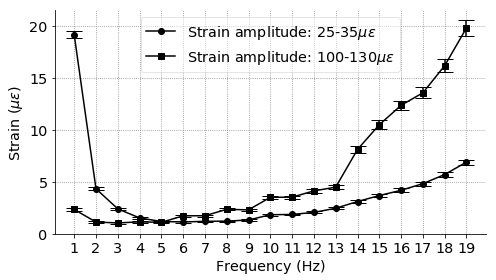

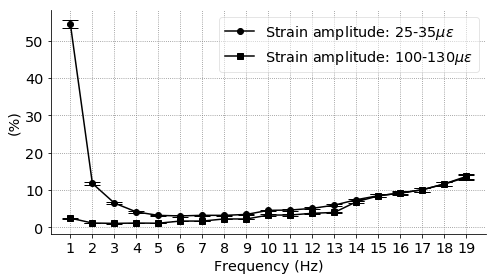

In [28]:
plot_experimental_results({'600mV': df_600mV_inStrain, '1600mV': df_1600mV_inStrain}, 
                          ustrainUnits=True, save2fig=False)

### 5.2 Plot results in voltage units

In [29]:
df_600mV_inV = dict2df(abs_pt_error_600mV_inV, rel_pt_error_600mV)
df_1600mV_inV = dict2df(abs_pt_error_1600mV_inV, rel_pt_error_1600mV)

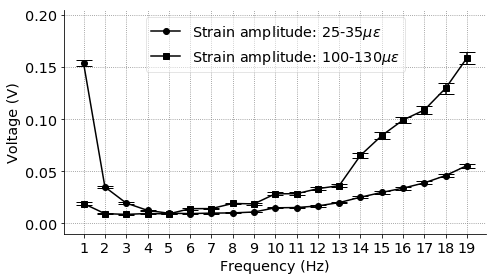

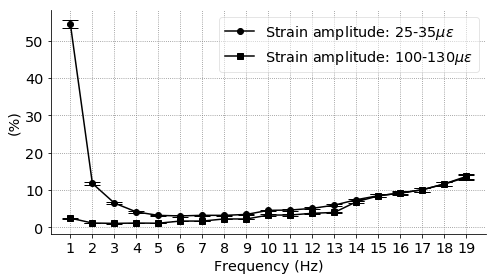

In [30]:
plot_experimental_results({'600mV': df_600mV_inV, '1600mV': df_1600mV_inV}, 
                          ustrainUnits=False, save2fig=True)